In [164]:
!pip install -U kaleido

In [165]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN

In [166]:
df=pd.read_csv('/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [167]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [168]:
df.shape

(7043, 21)

In [169]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [170]:
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [171]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Performing exploratary data analysis


In [172]:
#Understanding the balance of dataset by analysing churn
df['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


In [173]:
df['Churn'].value_counts(normalize=True)*100

,proportion
Churn,
No,73.463013
Yes,26.536987


Text(0, 0.5, 'Churn')

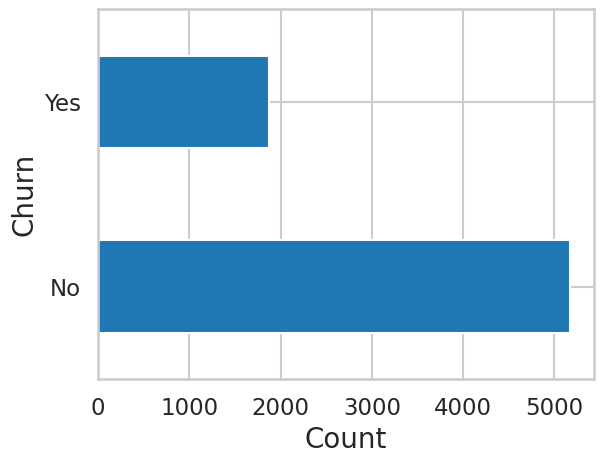

In [174]:
#Data is highly imbalanced, ratio = 73:27
df['Churn'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Churn')

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [176]:
#we will check the relation of target variable wrt other parameters
df1=df.copy()

In [177]:
#As total charges play a key role in these services we begin by analysing it
df1['TotalCharges']=pd.to_numeric(df1['TotalCharges'],errors='coerce')
df1['TotalCharges'].isnull().sum()

11

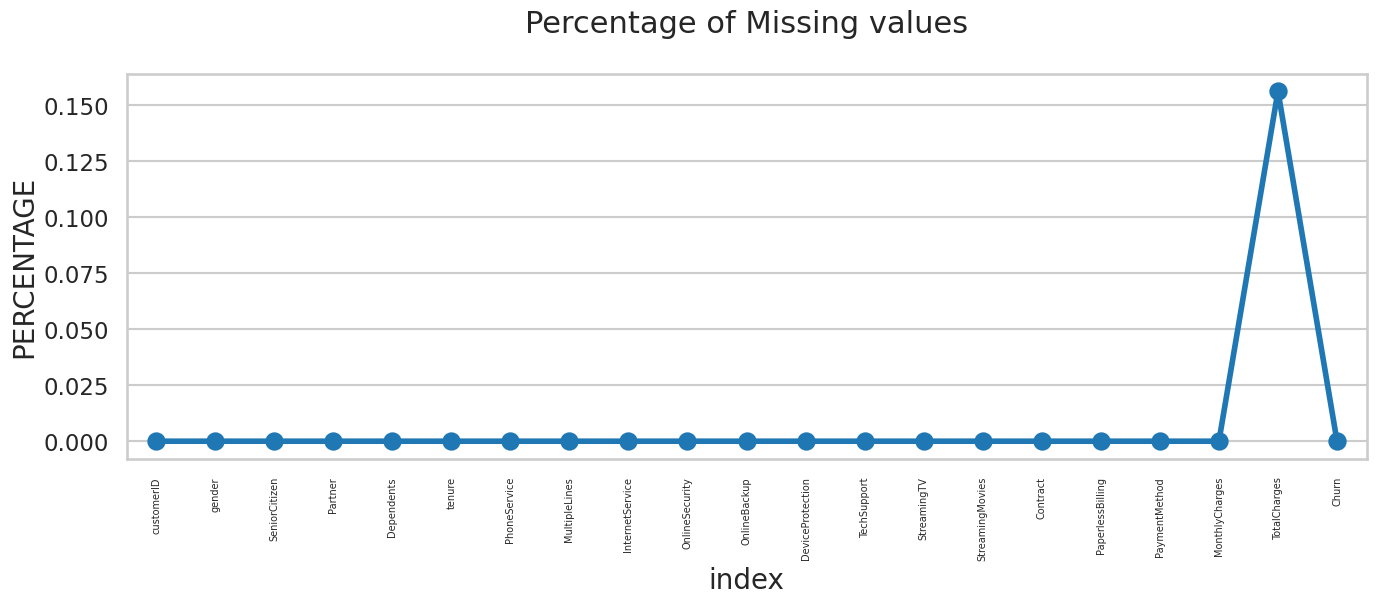

In [178]:
#percentage of null values among the feature columns
missing = pd.DataFrame((df1.isnull().sum())*100/df1.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot(x='index',y=0,data=missing)
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.show()

In [179]:
#adjusting the churners according to there tenure
labels=["{0}-{1}".format(i,i+11) for i in range (1,72,12)] # Changed {12} to {1} to match the second argument
df1['tenure_group']=pd.cut(df1.tenure,range(1,80,12),right=False,labels=labels)
df1['tenure_group'].value_counts()

,count
tenure_group,
1-12,2175
61-72,1407
13-24,1024
25-36,832
49-60,832
37-48,762


In [180]:
df1.drop(['tenure','customerID'],axis=1,inplace=True)
df1.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1-12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25-36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1-12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37-48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1-12


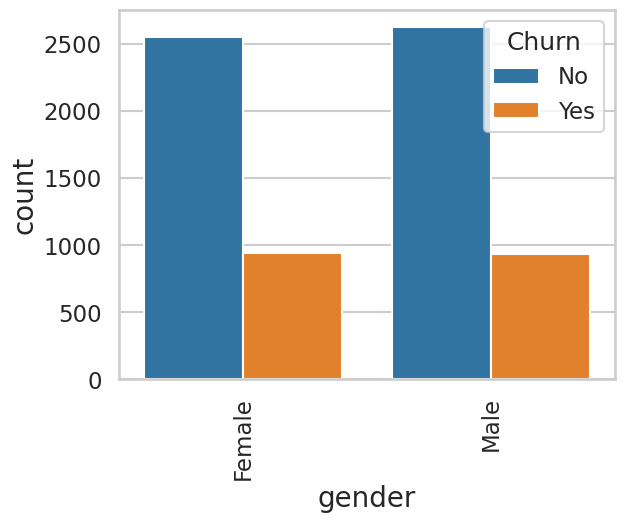

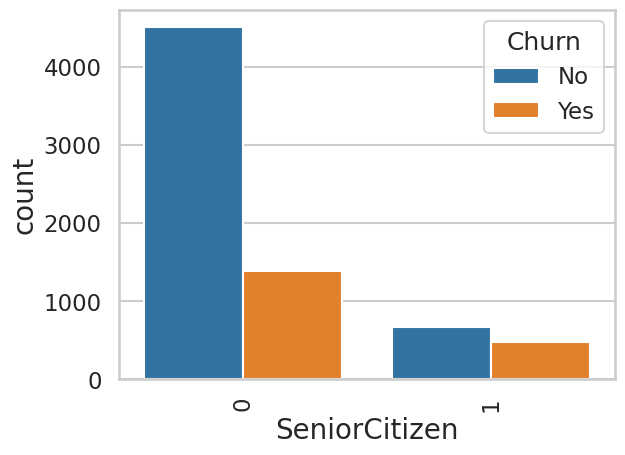

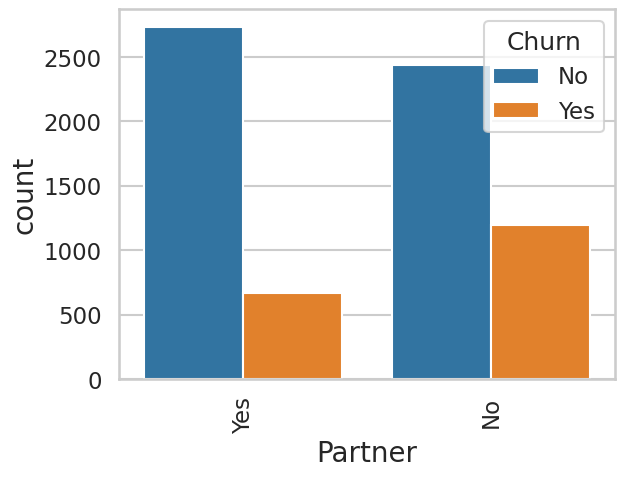

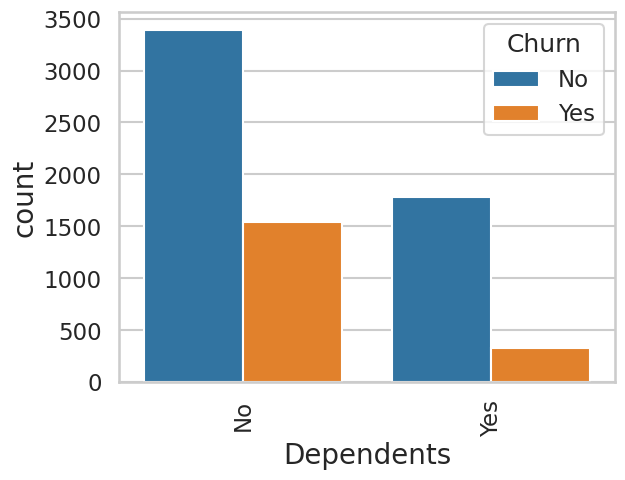

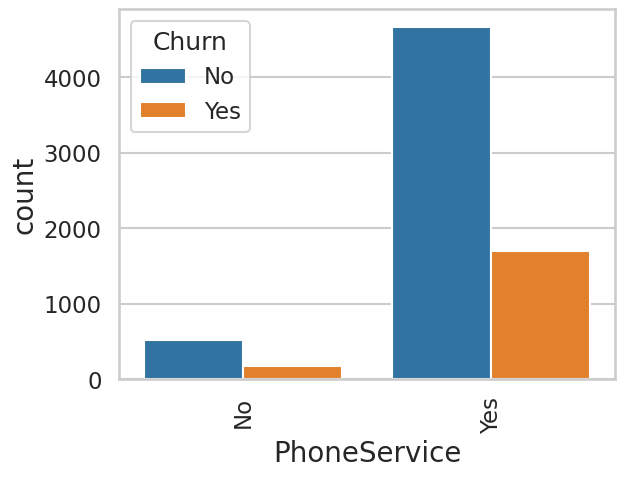

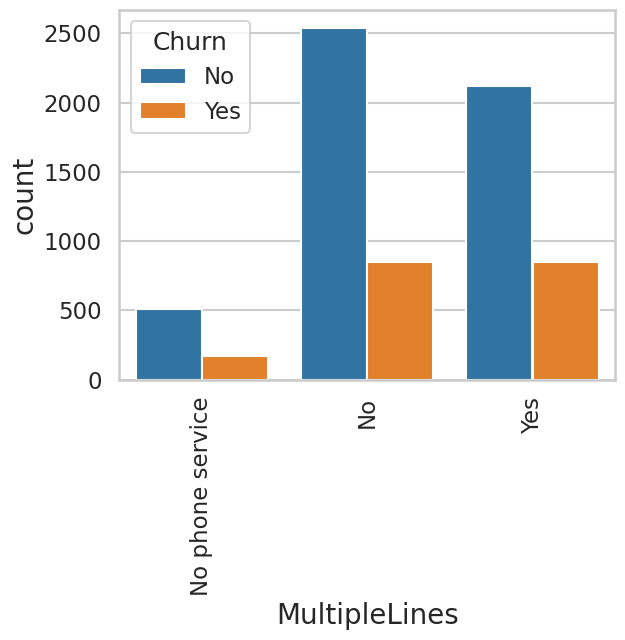

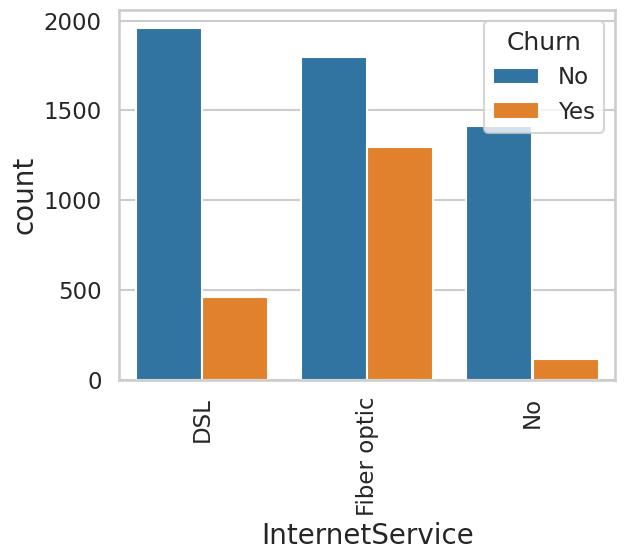

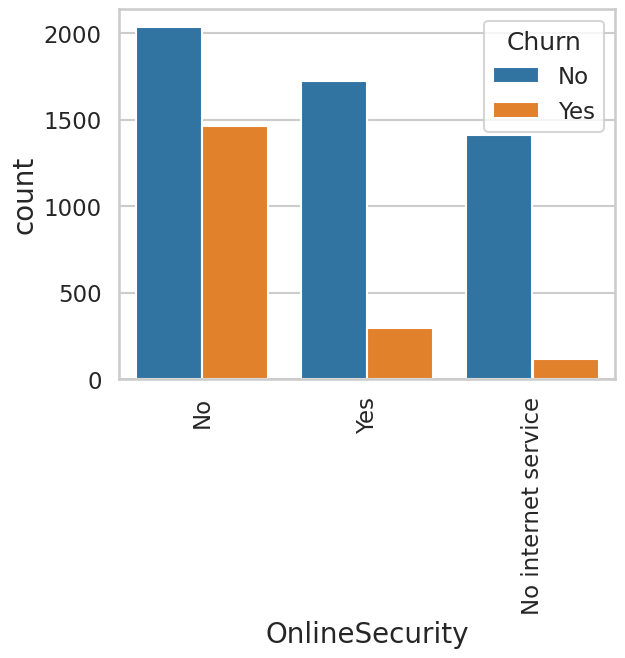

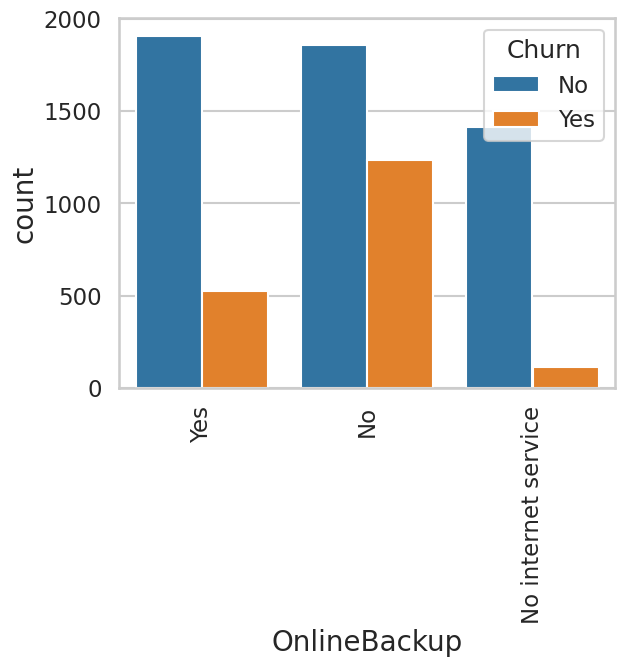

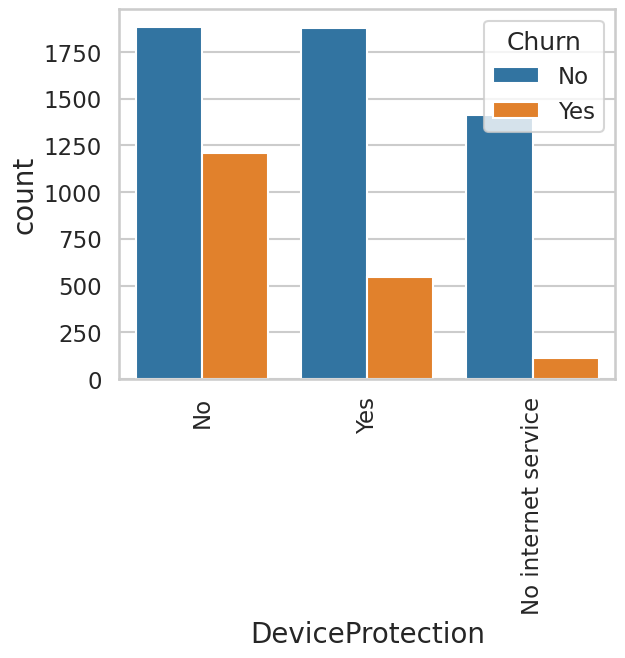

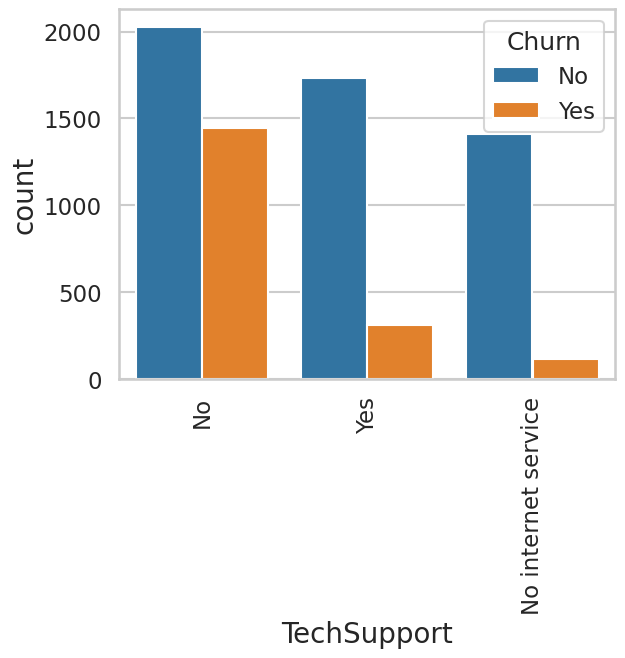

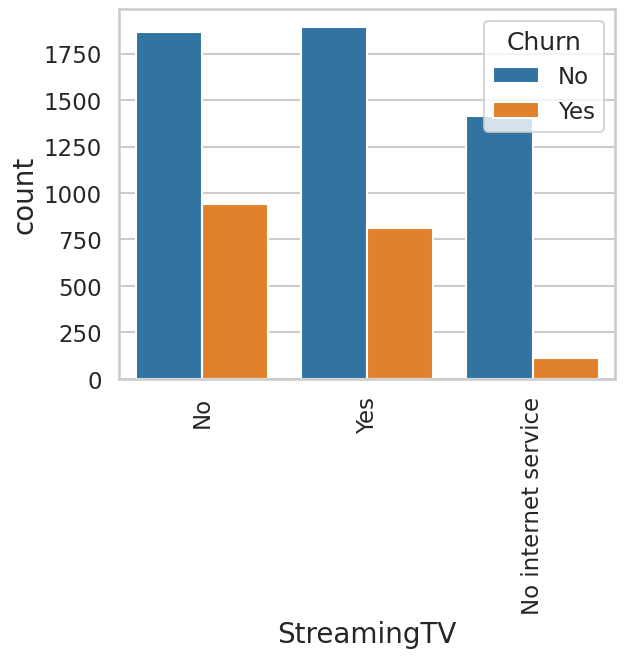

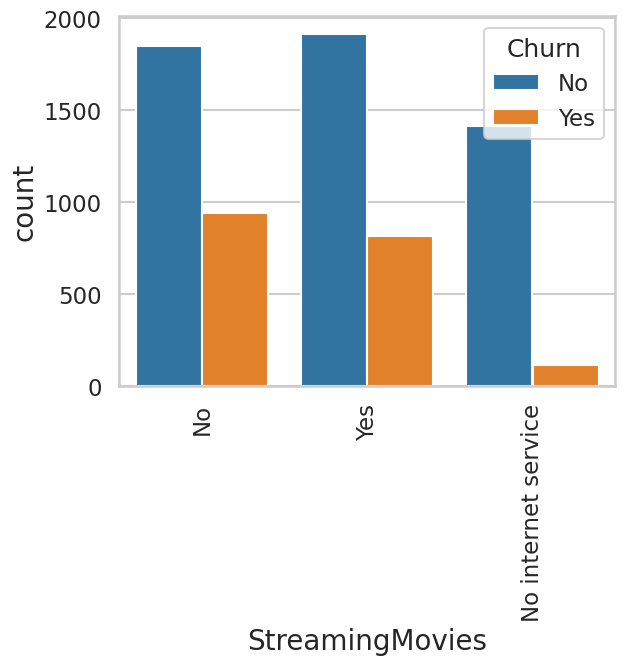

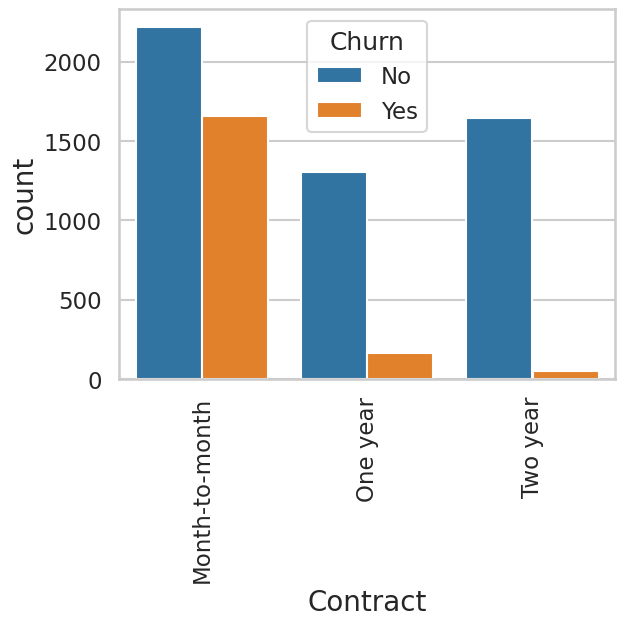

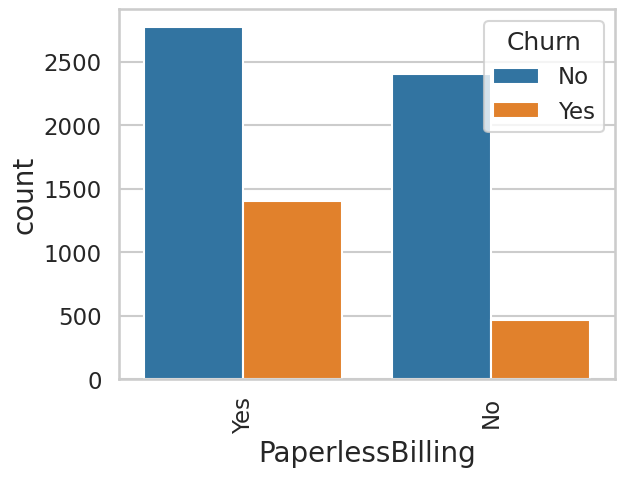

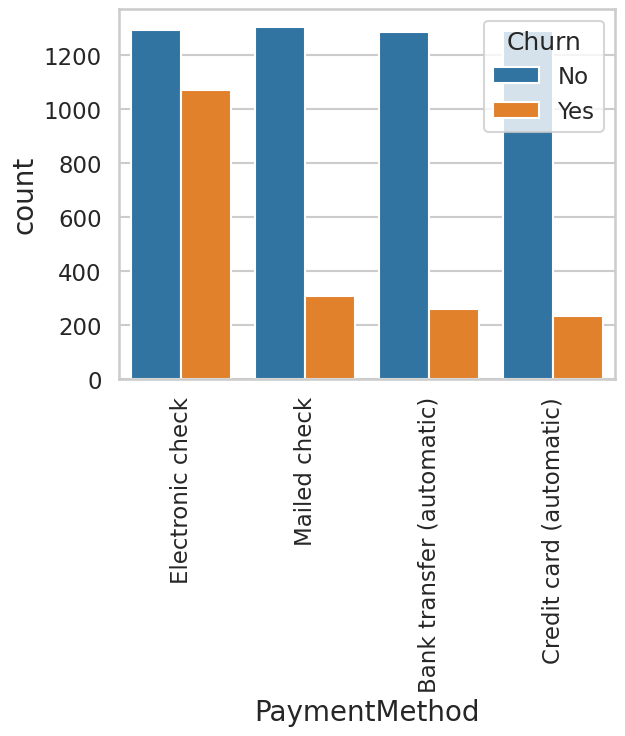

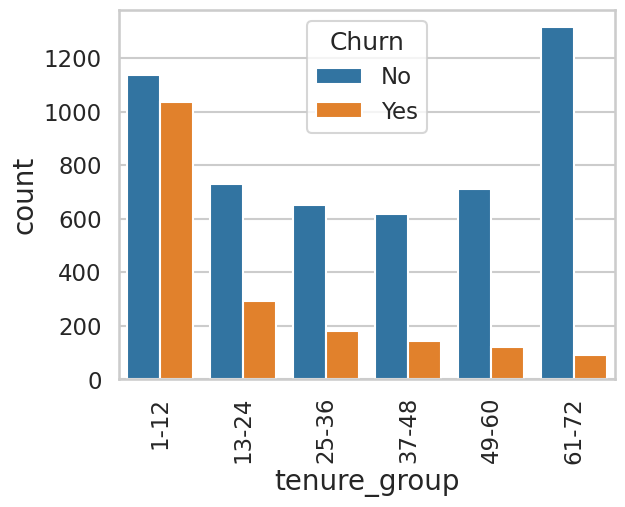

In [181]:
#univariate analysis
for i,predictor in enumerate(df1.drop(columns=['Churn','TotalCharges','MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=df1,x=predictor,hue='Churn')
    plt.xticks(rotation=90)

In [182]:
df1['Churn']=df1['Churn'].map({"Yes":1,"No":0})
df1.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1-12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25-36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1-12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,37-48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1-12


In [183]:
#Converting all the categorical values in dummy values using OHC
df2=pd.get_dummies(df1,sparse=False)
df2 = df2.replace({True: 1, False: 0})
df2.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1-12,tenure_group_13-24,tenure_group_25-36,tenure_group_37-48,tenure_group_49-60,tenure_group_61-72
0,0,29.85,29.85,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,56.95,1889.50,0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,53.85,108.15,1,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,0,42.30,1840.75,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,0,70.70,151.65,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0


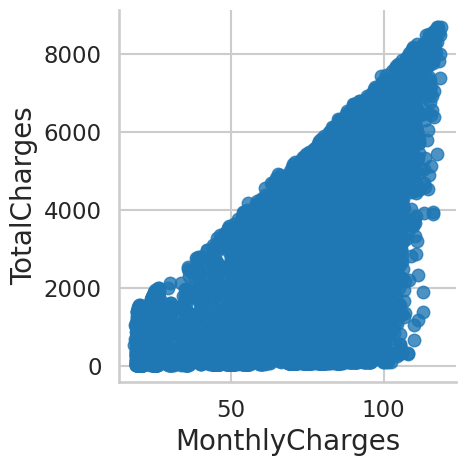

In [184]:
sns.lmplot(data=df1,x='MonthlyCharges',y='TotalCharges',fit_reg=False)#Both variables are in +ive corelation

Text(0.5, 1.0, 'Monthly charges by churn')

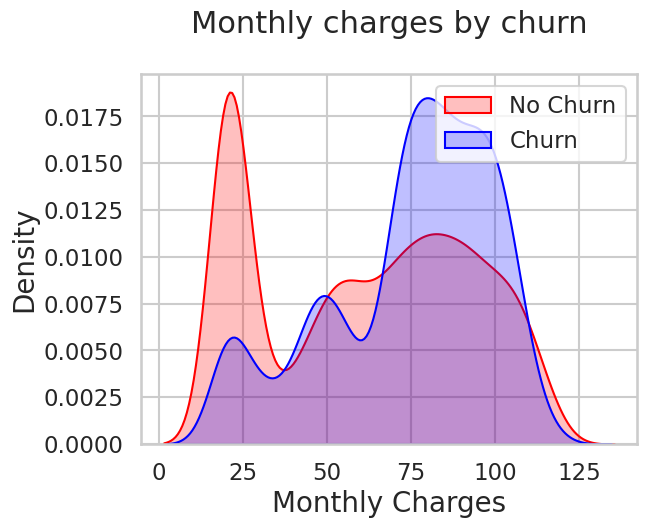

In [185]:
#compairing churn with monthly charge
Mth = sns.kdeplot(df1['MonthlyCharges'][(df1["Churn"] == 0) ],
                color="Red", fill = True)
Mth = sns.kdeplot(df1['MonthlyCharges'][(df1["Churn"] == 1) ],
                ax =Mth, color="Blue", fill= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

Text(0.5, 1.0, 'Total charges by churn')

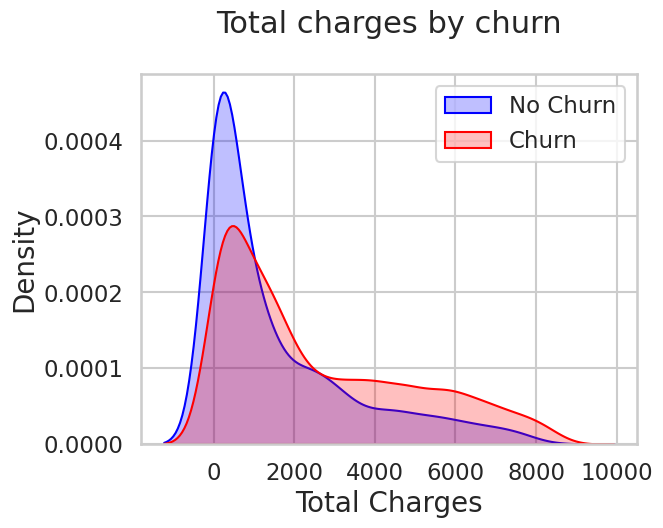

In [186]:
#compairing churn with total charge
t=sns.kdeplot(df1['TotalCharges'][(df1['Churn']==1)],color="blue",fill=True)
t=sns.kdeplot(df1['TotalCharges'][(df1['Churn']==0)],color="red",fill=True)
t.legend(["No Churn","Churn"],loc='upper right')
t.set_ylabel('Density')
t.set_xlabel('Total Charges')
t.set_title('Total charges by churn')

<Axes: >

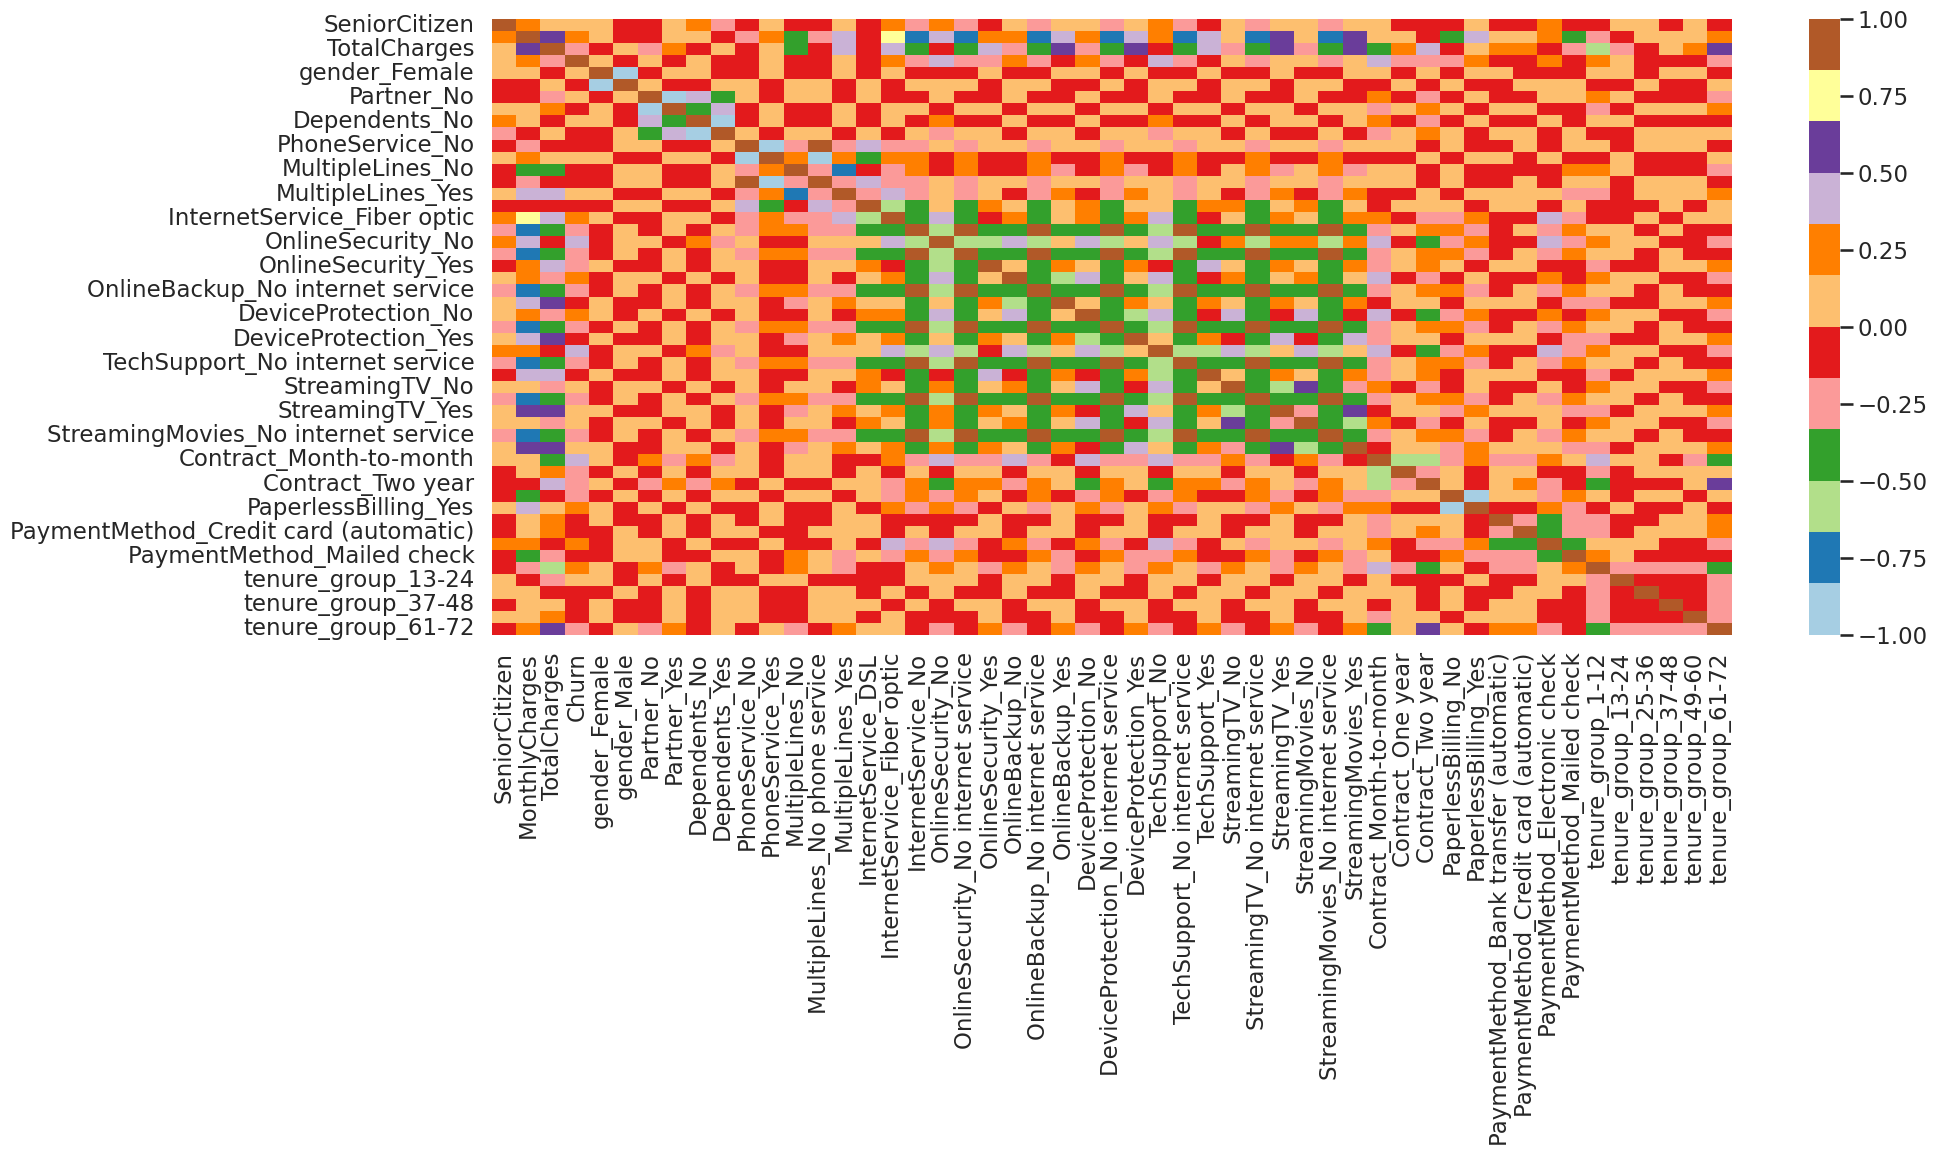

In [187]:
plt.figure(figsize=(20,8))
sns.heatmap(df2.corr(),cmap='Paired')

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.4, 0, '−0.4'),
  Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.20000000000000007, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6, 0, '0.6'),
  Text(0.8000000000000002, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

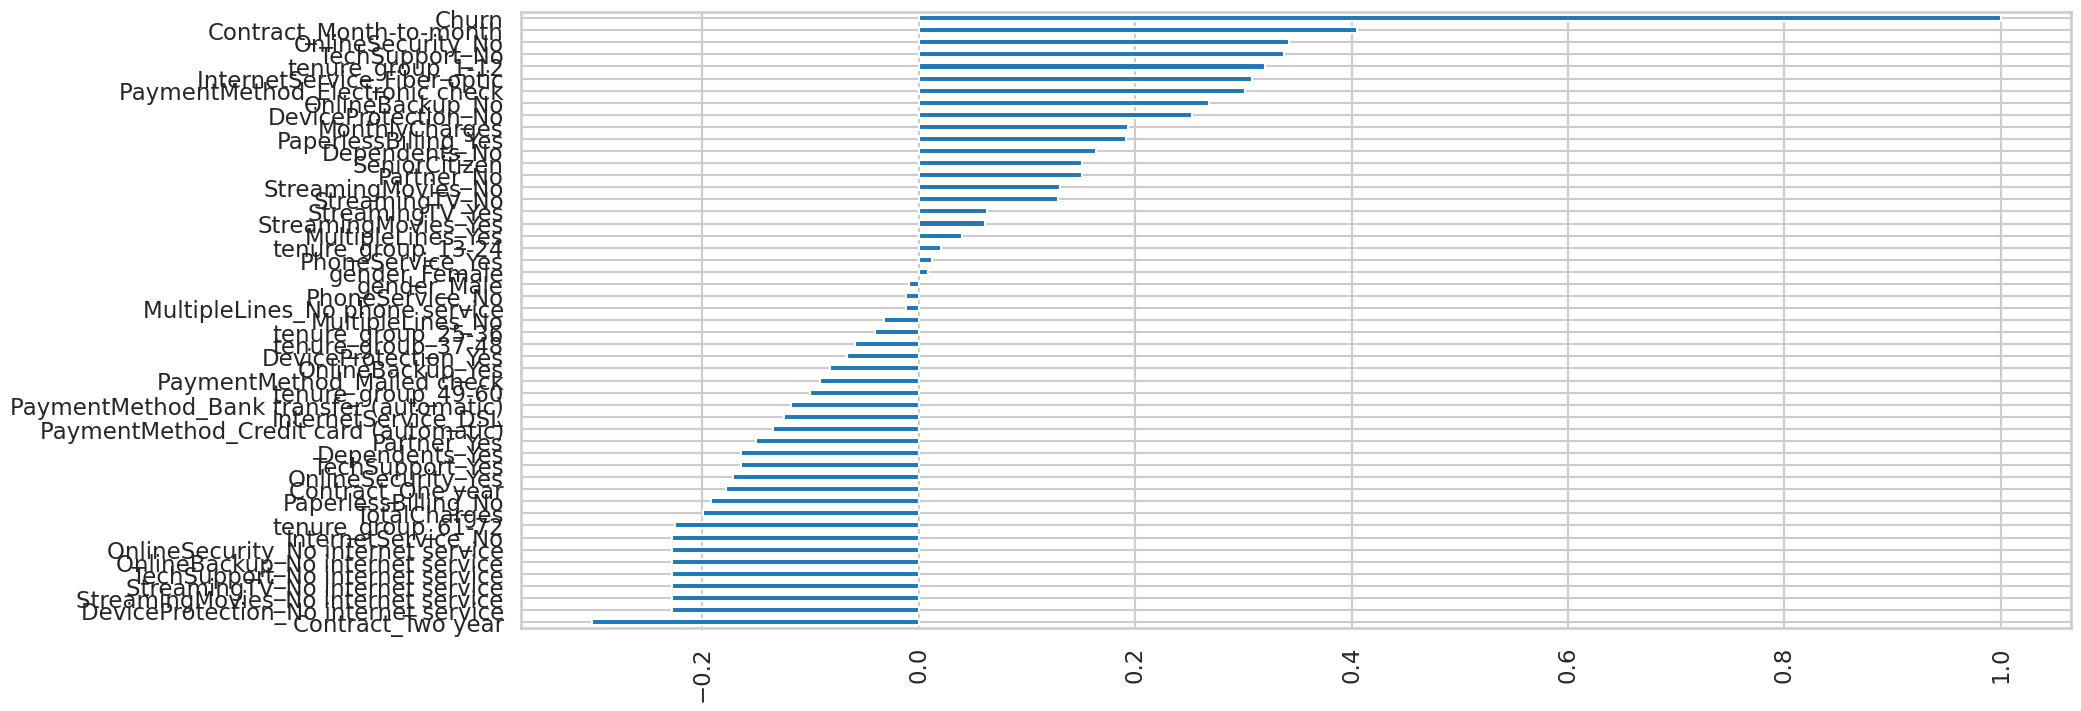

In [188]:
plt.figure(figsize=(20,8))
df2.corr()['Churn'].sort_values(ascending=True).plot(kind="barh")
plt.xticks(rotation=90)

Model building


In [189]:
x=df2.drop('Churn',axis=1)
x

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1-12,tenure_group_13-24,tenure_group_25-36,tenure_group_37-48,tenure_group_49-60,tenure_group_61-72
0,0,29.85,29.85,1,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,0
1,0,56.95,1889.50,0,1,1,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,53.85,108.15,0,1,1,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0,42.30,1840.75,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,0,70.70,151.65,1,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84.80,1990.50,0,1,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0
7039,0,103.20,7362.90,1,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,1
7040,0,29.60,346.45,1,0,0,1,0,1,1,...,0,0,1,0,1,0,0,0,0,0
7041,1,74.40,306.60,0,1,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0


In [190]:
y=df2['Churn']
y

,Churn
0,0
1,0
2,1
3,0
4,1
...,...
7038,0
7039,0
7040,0
7041,1


In [191]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)


In [192]:
dtc=DecisionTreeClassifier(criterion='gini',random_state=100,max_depth=6,min_samples_leaf=8)
dtc.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [193]:
y_pred=dtc.predict(x_test)
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [194]:
y_test

,Churn
6210,0
5206,0
948,1
3871,1
1697,0
...,...
2201,0
541,0
219,0
5129,0


In [195]:
dtc.score(x_test,y_test)

0.7821149751596878

In [196]:
print(classification_report(y_test,y_pred,labels=[0,1]))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1037
           1       0.60      0.52      0.56       372

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



As the data was inbalanced the accuracy is cursed thus we require to perform upsampling

In [197]:
print(confusion_matrix(y_test,y_pred))

[[908 129]
 [178 194]]


In [198]:
#to drop null values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
x = pd.DataFrame(imputer.fit_transform(x))

imputer = SimpleImputer(strategy='mean')
x = imputer.fit_transform(x)

sm=SMOTEENN()
x_resampled,y_resampled=sm.fit_resample(x,y)


In [199]:
x1_train,x1_test,y1_train,y1_test=train_test_split(x_resampled,y_resampled,test_size=0.2)

In [200]:
dtc1=DecisionTreeClassifier(criterion='gini',random_state=100,max_depth=6,min_samples_leaf=8)
dtc1.fit(x1_train,y1_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [201]:
y1_pred=dtc1.predict(x1_test)
y1_pred

array([1, 1, 0, ..., 0, 0, 1])

In [202]:
print(dtc1.score(x1_test,y1_test))

0.9202037351443124


In [203]:
print(classification_report(y1_test,y1_pred,labels=[0,1]))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       564
           1       0.90      0.95      0.93       614

    accuracy                           0.92      1178
   macro avg       0.92      0.92      0.92      1178
weighted avg       0.92      0.92      0.92      1178



In [204]:
print(confusion_matrix(y1_test,y1_pred))

[[502  62]
 [ 32 582]]


[Text(0.43819444444444444, 0.9285714285714286, 'x[35] <= 0.004\ngini = 0.494\nsamples = 4710\nvalue = [2102, 2608]'),
 Text(0.20972222222222223, 0.7857142857142857, 'x[15] <= 0.129\ngini = 0.106\nsamples = 1658\nvalue = [1565, 93]'),
 Text(0.1, 0.6428571428571429, 'x[17] <= 0.5\ngini = 0.03\nsamples = 1297\nvalue = [1277, 20]'),
 Text(0.05555555555555555, 0.5, 'x[1] <= 74.2\ngini = 0.011\nsamples = 1116\nvalue = [1110, 6]'),
 Text(0.03333333333333333, 0.35714285714285715, 'x[2] <= 233.65\ngini = 0.002\nsamples = 942\nvalue = [941, 1]'),
 Text(0.022222222222222223, 0.21428571428571427, 'x[2] <= 201.975\ngini = 0.048\nsamples = 41\nvalue = [40, 1]'),
 Text(0.011111111111111112, 0.07142857142857142, 'gini = 0.0\nsamples = 33\nvalue = [33, 0]'),
 Text(0.03333333333333333, 0.07142857142857142, 'gini = 0.219\nsamples = 8\nvalue = [7, 1]'),
 Text(0.044444444444444446, 0.21428571428571427, 'gini = 0.0\nsamples = 901\nvalue = [901, 0]'),
 Text(0.07777777777777778, 0.35714285714285715, 'x[2] <= 

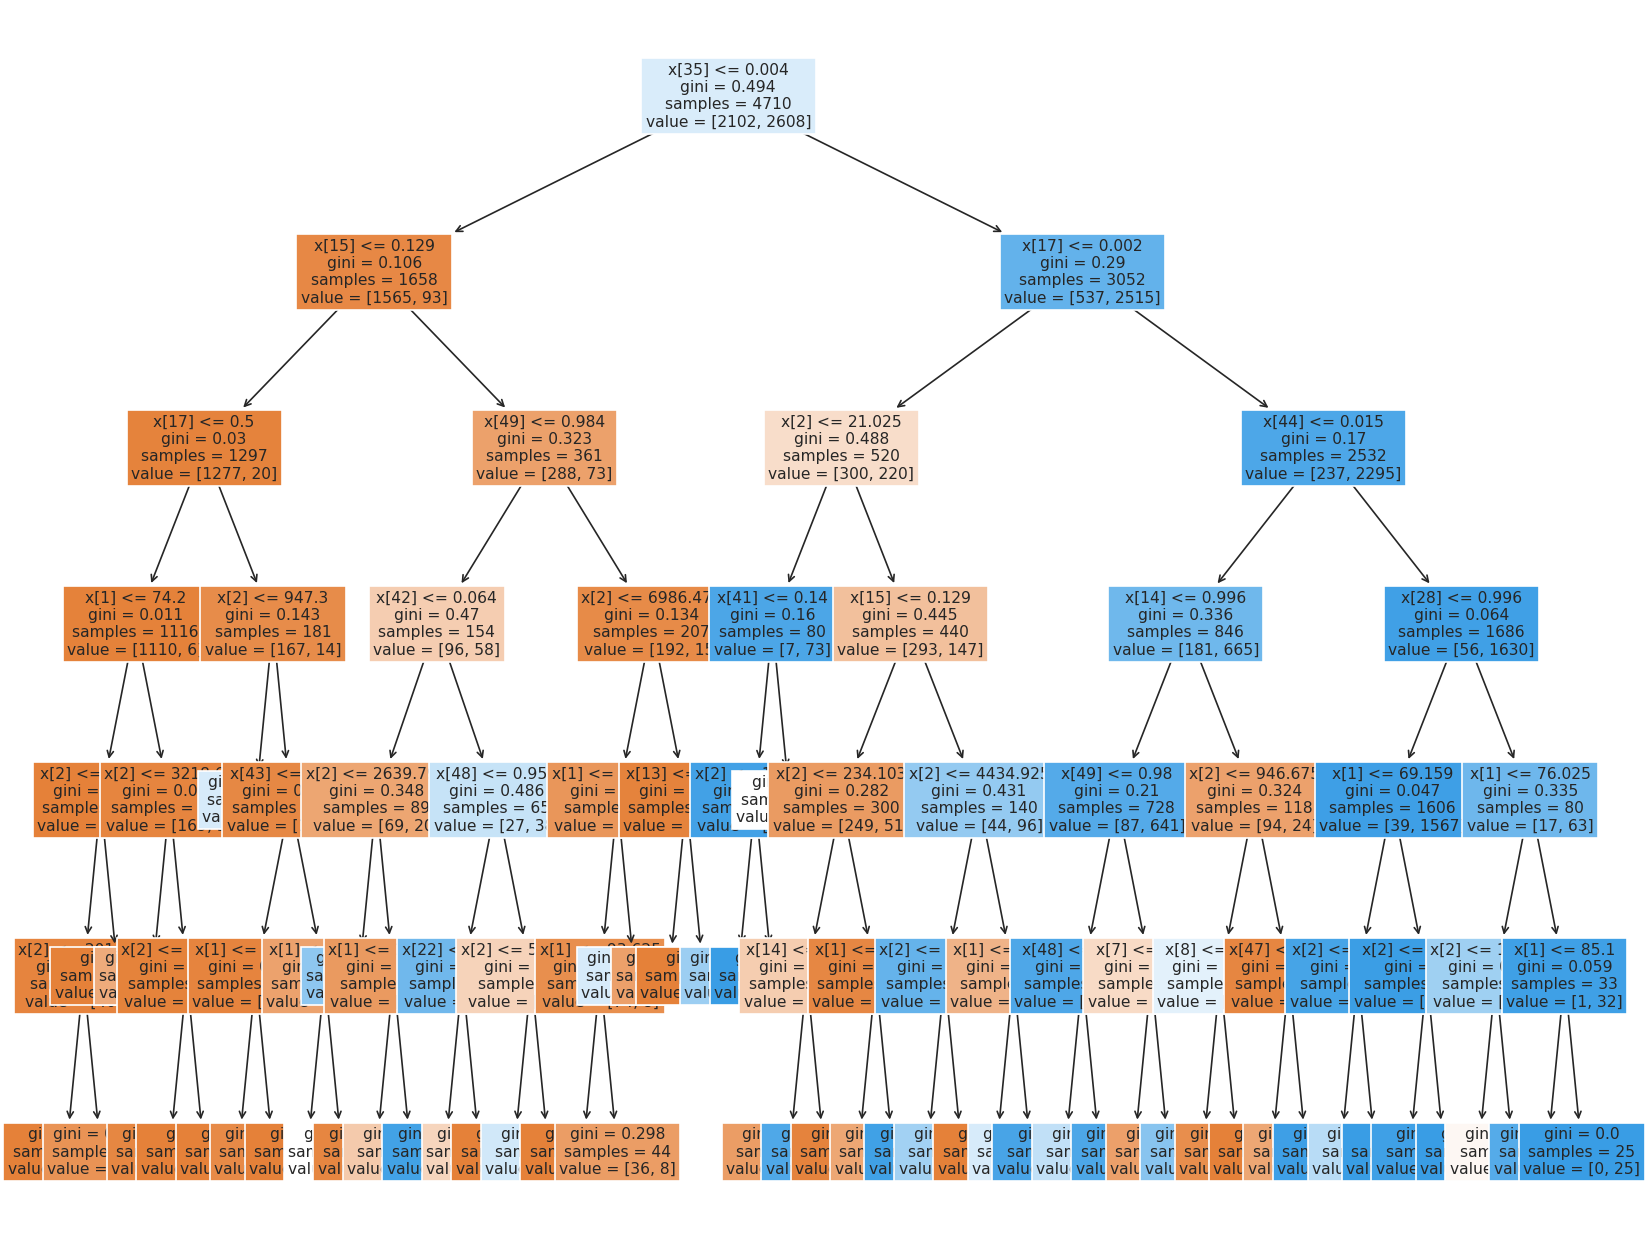

In [205]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure
figure(figsize=(25,20),dpi=80)
plot_tree(dtc1,filled=True,fontsize=14)

In [206]:
from sklearn.ensemble import RandomForestClassifier


In [207]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
x_train_imputed = imputer.fit_transform(x_train)

model_rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)
model_rf.fit(x_train_imputed, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [208]:
RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)
y_pred=model_rf.predict(x_test)
model_rf.score(x_test,y_test)
print(classification_report(y_test, y_pred, labels=[0,1]))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
sm=SMOTEENN()
x_resampled1,y_resampled1=sm.fit_resample(x,y)

In [ ]:
x2_train,x2_test,y2_train,y2_test=train_test_split(x_resampled1,y_resampled1,test_size=0.2)

In [ ]:
rfc=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)


In [ ]:
rfc.fit(x2_train,y2_train)

In [ ]:
print(rfc.score(x2_test,y2_test))
y2_pred=rfc.predict(x2_test)

In [ ]:
print(classification_report(y2_test,y2_pred))

print(confusion_matrix(y2_test,y2_pred))